# Dependencies and Data Loading

In [1]:
import os
import sys
import time
import numpy as np
import random
import pandas as pd
import scipy.io as sio
from collections import Counter
from itertools import product
from scipy.io import loadmat
import tensorflow as tf
from keras.utils import np_utils
from tensorflow.keras import optimizers,backend
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense, Flatten, Lambda, concatenate
from keras.layers.convolutional import Convolution1D,MaxPooling1D
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# load training data 

# synthetic training data
filename = '/content/drive/My Drive/Manuscript_EJNMMI_2021/Github/Traindata_synthetic.mat'
input = loadmat(filename)
input_spectra_1 = input['spectra_syn_train']
labels_1 = input['pH_labels_syn_train']

# denoised kidney training data 
filename = '/content/drive/My Drive/Manuscript_EJNMMI_2021/Github/Traindata_kidney_aug.mat'
input = loadmat(filename)
input_spectra_2 = input['spectra_kidney_aug_train']
labels_2 = input['pH_labels_kidney_aug_train']

# replace n spectra of from the synthetic data depending on the size of the real data
n_2keep = len(input_spectra_1) - len(input_spectra_2)

# Combine training data
input_spectra = np.append(input_spectra_1[0:n_2keep], input_spectra_2 , axis=0)
labels = np.append(labels_1[0:n_2keep], labels_2,axis=0)

In [6]:
display(input_spectra.shape)
display(labels.shape)

(10000, 1024)

(10000, 3)

In [7]:
# load testdata - synthetic spectra
filename = '/content/drive/My Drive/Manuscript_EJNMMI_2021/Github/Testdata_synthetic.mat'
test_aug = loadmat(filename)
test_input_spectra_aug = test_aug['spectra_syn_test']
test_labels_aug = test_aug['pH_labels_syn_test']

# load testdata - kidney
filename = '/content/drive/My Drive/Manuscript_EJNMMI_2021/Github/Testdata_kidney.mat'
test = loadmat(filename)
test_input_spectra = test['spectra_kidney_test']
test_labels = test['pH_labels_kidney_test']

In [8]:
display(test_input_spectra_aug.shape)
display(test_labels_aug.shape)
display(test_input_spectra.shape)
display(test_labels.shape)

(20, 1024)

(20, 3)

(8, 1024)

(8, 3)

# Preprocessing

In [9]:
X_train, X_val, y_train, y_val = train_test_split(input_spectra, labels, test_size=0.15, random_state=13)

X_train = np.array(X_train).astype('float32')
X_train = X_train.reshape(X_train.shape + (1,))
X_val = np.array(X_val).astype('float32')
X_val = X_val.reshape(X_val.shape + (1,))

X_test = np.array(test_input_spectra).astype('float32')
X_test = X_test.reshape(X_test.shape + (1,))
X_test_aug = np.array(test_input_spectra_aug).astype('float32')
X_test_aug = X_test_aug.reshape(X_test_aug.shape + (1,))

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(test_labels)
y_test_aug = np.array(test_labels_aug)

print("Total of "+str(len(X_train))+" training samples.")
print("Total of "+str(len(X_val))+" validation samples.")

Total of 8500 training samples.
Total of 1500 validation samples.


Total of 8500 training samples.
Total of 1500 validation samples.


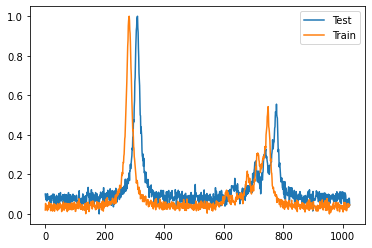

In [10]:
displayind = 2
print("Total of "+str(len(X_train))+" training samples.")
print("Total of "+str(len(X_val))+" validation samples.")
plt.plot(X_train[displayind],label='input')
plt.plot(X_val[displayind],label='ground truth')
plt.legend(['Test', 'Train'], loc='upper right')
plt.show()

# Model Architecture

In [11]:
def mapping_to_target_range( x, target_min=6.32, target_max=7.44) :
    x02 = backend.tanh(x) + 1 
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min

In [12]:
# default random initialization for weights
backend.clear_session()

model = Sequential()
model.add(Convolution1D(filters=4, kernel_size=300, padding='same', input_shape=(1024,1), activation='relu'))
model.add(MaxPooling1D())

model.add(Convolution1D(filters=4, kernel_size=150, padding='same', activation='relu'))
model.add(MaxPooling1D())

model.add(Convolution1D(filters=8, kernel_size=50, padding='same', activation='relu'))
model.add(MaxPooling1D())

model.add(Convolution1D(filters=8, kernel_size=20, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.10))

model.add(Flatten())
model.add(Dense(3,activation=mapping_to_target_range))
nadam = optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=nadam)

print(model.summary())
print("CNN Model created.")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1024, 4)           1204      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 512, 4)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 512, 4)            2404      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 256, 4)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 256, 8)            1608      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 128, 8)           0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


# Training

In [13]:
epochs = 400
batch_size = 200

best_model_file = '/content/drive/My Drive/weights/KidNeYronal_model_cnn-mix.h5'
start = time.time()

best_model = ModelCheckpoint(best_model_file, monitor='loss', verbose = 1, save_best_only=True, save_weights_only=False)
hist = model.fit(X_train,
                 y_train,
                 validation_data=(X_val, y_val),  
                 epochs=epochs,
                 batch_size=batch_size,
                 callbacks = [best_model],
                 shuffle = True,
                 verbose=1)

print("training time: ",time.time()-start)
print("done")

Epoch 1/400
43/43 [==============================] - ETA: 0s - loss: 0.0233
Epoch 00001: loss improved from inf to 0.02331, saving model to /content/drive/My Drive/weights/KidNeYronal_model_cnn-mix.h5
43/43 [==============================] - 34s 573ms/step - loss: 0.0233 - val_loss: 0.0024
Epoch 2/400
41/43 [===========================>..] - ETA: 0s - loss: 0.0029
Epoch 00002: loss improved from 0.02331 to 0.00288, saving model to /content/drive/My Drive/weights/KidNeYronal_model_cnn-mix.h5
43/43 [==============================] - 2s 38ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 3/400
43/43 [==============================] - ETA: 0s - loss: 0.0026
Epoch 00003: loss improved from 0.00288 to 0.00255, saving model to /content/drive/My Drive/weights/KidNeYronal_model_cnn-mix.h5
43/43 [==============================] - 1s 34ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 4/400
43/43 [==============================] - ETA: 0s - loss: 0.0023
Epoch 00004: loss improved from 0.00255 to 0.00

(0.0, 0.01)

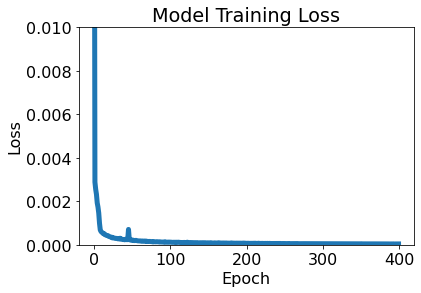

In [14]:
plt.rcParams.update({'font.size': 16})
plt.plot(hist.history['loss'], linewidth = 5)
plt.title('Model Training Loss')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.ylim(top=0.01,bottom=0) 

(0.0, 0.005)

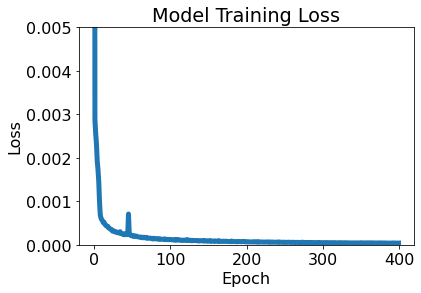

In [15]:
plt.plot(hist.history['loss'], linewidth = 5)
plt.title('Model Training Loss')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.ylim(top=0.005,bottom=0) 

(0.0, 0.01)

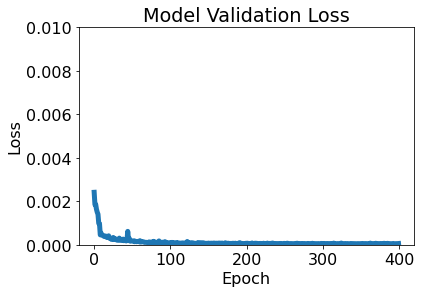

In [16]:
# 4
plt.plot(hist.history['val_loss'], linewidth = 5)
plt.title('Model Validation Loss')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.ylim(top=0.01,bottom=0) 

(0.0, 0.005)

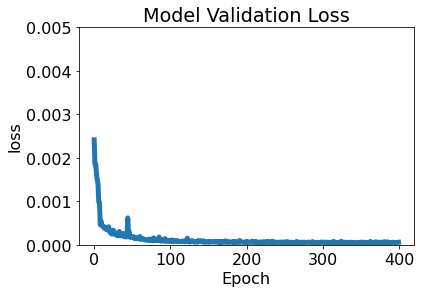

In [17]:
plt.plot(hist.history['val_loss'], linewidth = 5)
plt.title('Model Validation Loss')
plt.ylabel('loss'), plt.xlabel('Epoch')
plt.ylim(top=0.005,bottom=0) 

# Testing Model Accuracy - Kidney data


In [18]:
predict = model.predict(X_test)
dis_index = 0     #index for the test data

In [19]:
def plot_predict_gt(predict_aug,y_test_aug):
  predict_output = pd.DataFrame({'predict':predict_aug,'ground truth':y_test_aug})
  predict_output = pd.DataFrame.transpose(predict_output)
  print('test: ',dis_index+1)
  print(predict_output)
  plt.figure()
  plt.plot(X_test[dis_index,:] )
  plt.title('spect= %i' %(dis_index+1))
  plt.ylabel('Intensity')
  print('\n')

test:  1
                     0         1         2
predict       7.421082  7.154658  6.725913
ground truth  7.429000  7.146000  6.739000


test:  2
                     0         1         2
predict       7.344434  7.102538  6.390507
ground truth  7.363000  7.103000  6.414000


test:  3
                     0         1         2
predict       7.358472  7.101253  6.391484
ground truth  7.332000  7.118000  6.381000


test:  4
                     0         1         2
predict       7.396151  6.977017  6.353616
ground truth  7.395000  6.970000  6.326000


test:  5
                     0        1         2
predict       7.354318  7.15169  6.744155
ground truth  7.351000  7.16600  6.750000


test:  6
                     0         1         2
predict       7.391236  7.028977  6.442289
ground truth  7.396000  7.045000  6.529000


test:  7
                    0         1         2
predict       7.42204  7.151271  6.749463
ground truth  7.43100  7.150000  6.768000


test:  8
                 

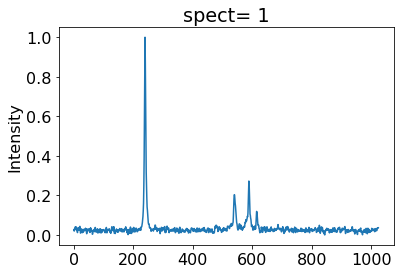

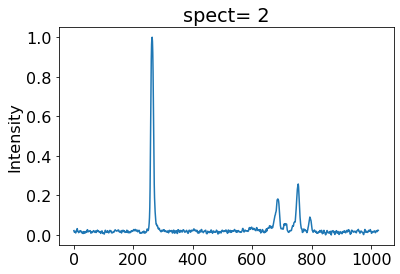

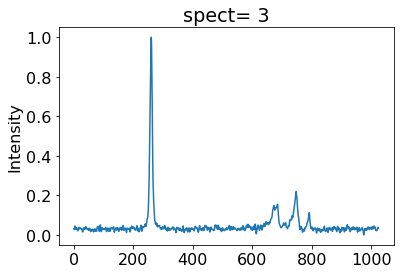

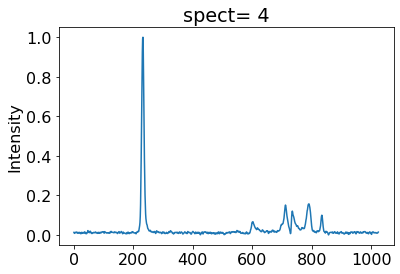

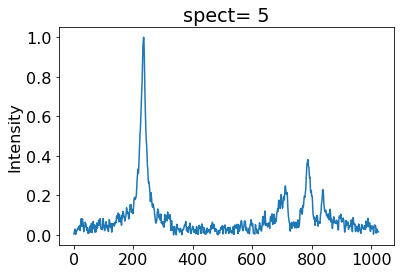

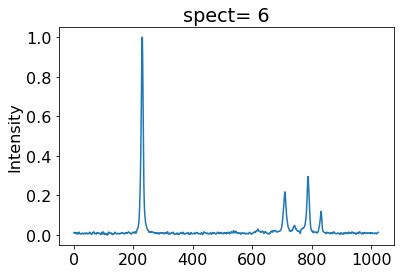

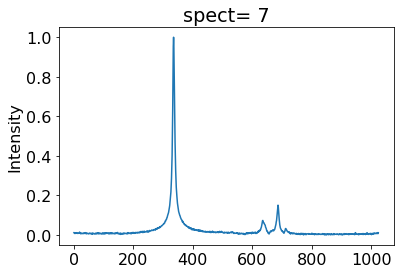

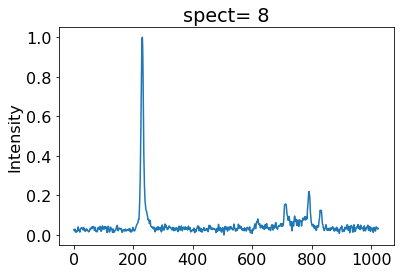

In [20]:
dis_index = 0
for idx in range(len(predict)):
  plot_predict_gt(predict[dis_index,:],y_test[dis_index,:])
  dis_index +=1

# Testing Model Accuracy - Synthetic data


In [21]:
predict_aug = model.predict(X_test_aug)

In [22]:
def print_predict_gt(predict_aug,y_test_aug):
  predict_output = pd.DataFrame({'predict':predict_aug,'ground truth':y_test_aug})
  predict_output = pd.DataFrame.transpose(predict_output)
  print('test: ',dis_index+1)
  print(predict_output)

In [23]:
dis_index = 0
for idx in range(len(predict_aug)):
  print_predict_gt(predict_aug[dis_index,:],y_test_aug[dis_index,:])
  dis_index +=1


test:  1
                     0         1         2
predict       7.365051  7.075047  6.513275
ground truth  7.366038  7.071987  6.522446
test:  2
                    0         1         2
predict       7.40712  7.045247  6.725577
ground truth  7.44000  7.006862  6.779162
test:  3
                     0         1         2
predict       7.367858  7.104126  6.477282
ground truth  7.367518  7.109335  6.486110
test:  4
                     0         1         2
predict       7.397996  7.032157  6.515519
ground truth  7.393396  7.006035  6.516890
test:  5
                     0         1         2
predict       7.394650  7.075593  6.413971
ground truth  7.405328  7.071277  6.422578
test:  6
                     0         1         2
predict       7.380822  7.019761  6.564424
ground truth  7.375795  7.023096  6.567435
test:  7
                     0         1         2
predict       7.398026  7.062266  6.360310
ground truth  7.400738  7.062025  6.364269
test:  8
                     0      